# COVID-19 RADIOGRAPHY DATABASE (Winner of the COVID-19 Dataset Award by Kaggle Community)

https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


In [1]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import keras
import numpy as np
from keras.layers import Dense, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import tensorflow as tf
from keras.applications import VGG16, ResNet50
from keras.optimizers import Adam
from keras import Input
from keras.utils import to_categorical
import os
import random

In [2]:
dimen=224
num_channels = 3
batch_size = 74

In [3]:
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database
! unzip -q /content/covid19-radiography-database.zip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 99% 770M/778M [00:10<00:00, 117MB/s]
100% 778M/778M [00:11<00:00, 74.0MB/s]


In [4]:
import shutil

shutil.rmtree('/content/COVID-19_Radiography_Dataset/COVID/masks')
shutil.rmtree('/content/COVID-19_Radiography_Dataset/Lung_Opacity/masks')
shutil.rmtree('/content/COVID-19_Radiography_Dataset/Normal/masks')
shutil.rmtree('/content/COVID-19_Radiography_Dataset/Viral Pneumonia/masks')

In [4]:
covid =len(os.listdir('/content/COVID-19_Radiography_Dataset/COVID/images'))
Lung_Opacity = len(os.listdir('/content/COVID-19_Radiography_Dataset/Lung_Opacity/images'))
Normal = len(os.listdir('/content/COVID-19_Radiography_Dataset/Normal/images'))
Viral_Pneumonia =len(os.listdir('/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images'))

print(f"covid: {covid}")
print(f"Lung_Opacity: {Lung_Opacity}")
print(f"Normal: {Normal}")
print(f"Viral_Pneumonia: {Viral_Pneumonia})")

covid: 3616
Lung_Opacity: 6012
Normal: 10192
Viral_Pneumonia: 1345)


In [5]:
path = r'/content/COVID-19_Radiography_Dataset/Normal/images'# You can provide the path here
n = 7000 # Number of random images to be removed
img_names = os.listdir(path)  # Get image names in folder
img_names = random.sample(img_names, n)  # Pick 2500 random images
for image in img_names:  # Go over each image name to be deleted
    f = os.path.join(path, image)  # Create valid path to image
    os.remove(f)  # Remove the image

path = r'/content/COVID-19_Radiography_Dataset/Lung_Opacity/images'# You can provide the path here
n = 3000 # Number of random images to be removed
img_names = os.listdir(path)  # Get image names in folder
img_names = random.sample(img_names, n)  # Pick 2500 random images
for image in img_names:  # Go over each image name to be deleted
    f = os.path.join(path, image)  # Create valid path to image
    os.remove(f)  # Remove the image

In [20]:
def display_images_in_grid(folder_path, num_images_per_class=5):
    """Displays images from a directory in a grid, classwise.

    Args:
        folder_path: Path to the directory containing images.
        num_images_per_class: Number of images to display per class.
    """
    class_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    num_classes = len(class_folders)

    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 15))

    for i, class_folder in enumerate(class_folders):
        image_files = os.listdir(os.path.join(folder_path, class_folder, 'images'))
        image_files = np.random.choice(image_files, num_images_per_class, replace=False)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, class_folder, 'images', image_file)
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(class_folder)

    plt.tight_layout()
    plt.show()

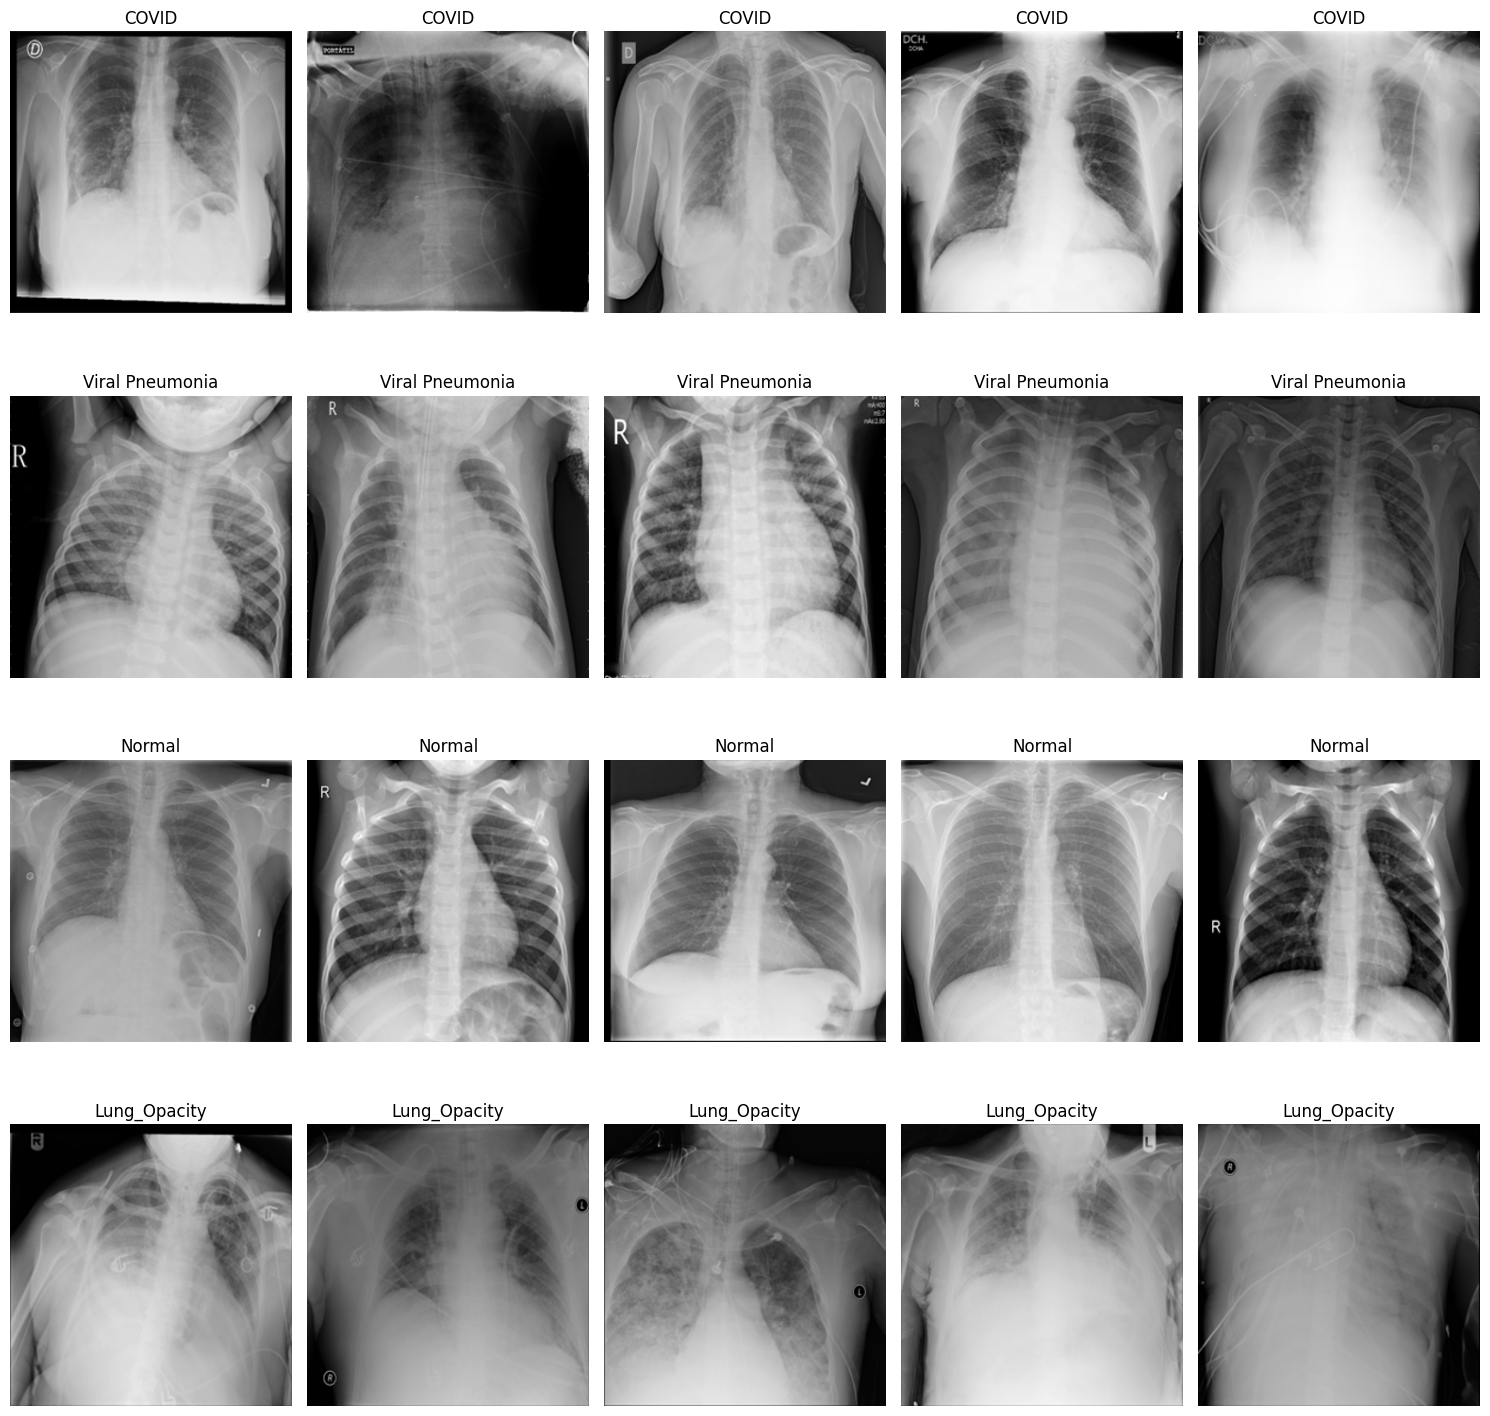

In [21]:
# Example usage:
display_images_in_grid('/content/COVID-19_Radiography_Dataset', num_images_per_class=5)

The CXR images in dataset seems to have low resolution and consderable noise. The lungs condition is difficult to determine due to unevenly distributed intesity over range of image pixels.

To understand the distinction among the classes is difficut to understad due to uneven distribution of pixel intensisty.

Several image enhacement techniques can be applied to produce more clear image dataset which has more fine features to be learned by the model.

In [6]:
def hisEqulColor(img):
    ycrcb = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
    channels = cv.split(ycrcb)
    cv.equalizeHist(channels[0], channels[0])
    cv.merge(channels, ycrcb)
    eq_img = cv.cvtColor(ycrcb, cv.COLOR_YCrCb2BGR)
    return eq_img

def process_images(folder_path, output_folder):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path)
            if img is not None:
                equalized_img = hisEqulColor(img)
                output_path = os.path.join(output_folder, filename)
                cv.imwrite(output_path, equalized_img)


def get_perf_metric(his, model):

  #Plot the perforane of model while training
  plt.plot(his.history['accuracy'], label='train acc')
  plt.plot(his.history['val_accuracy'], label='val acc')
  plt.legend()
  #plt.savefig('acc-graph.png')
  plt.show()

  plt.plot(his.history['loss'],label='train loss')
  plt.plot(his.history['val_loss'],label='val loss')
  plt.legend()
  #plt.savefig('loss-graph.png')
  plt.show()

  #Performance Metrics
  preds = model.predict(val)
  y_pred = np.argmax(preds, axis=1)
  print(y_pred)
  g_dict = val.class_indices
  classes = list(g_dict.keys())

  # Classification report
  print(classification_report(val.classes, y_pred, target_names= classes))

  # Confusion matrix
  cm = confusion_matrix(val.classes, y_pred)
  sns.heatmap(cm, annot = True)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

In [7]:
# Create output folder if it doesn't exist
output_root = '/content/COVID-19_Radiography_Dataset_Processed'
os.makedirs(output_root, exist_ok=True)

# Process images in each subfolder
for root, dirs, files in os.walk('/content/COVID-19_Radiography_Dataset'):
    for dir in dirs:
        if dir in os.listdir('/content/COVID-19_Radiography_Dataset'):
          folder_path = os.path.join(root, dir, 'images')
          output_folder = os.path.join(output_root, dir, 'images')
          os.makedirs(output_folder, exist_ok=True)
          process_images(folder_path, output_folder)

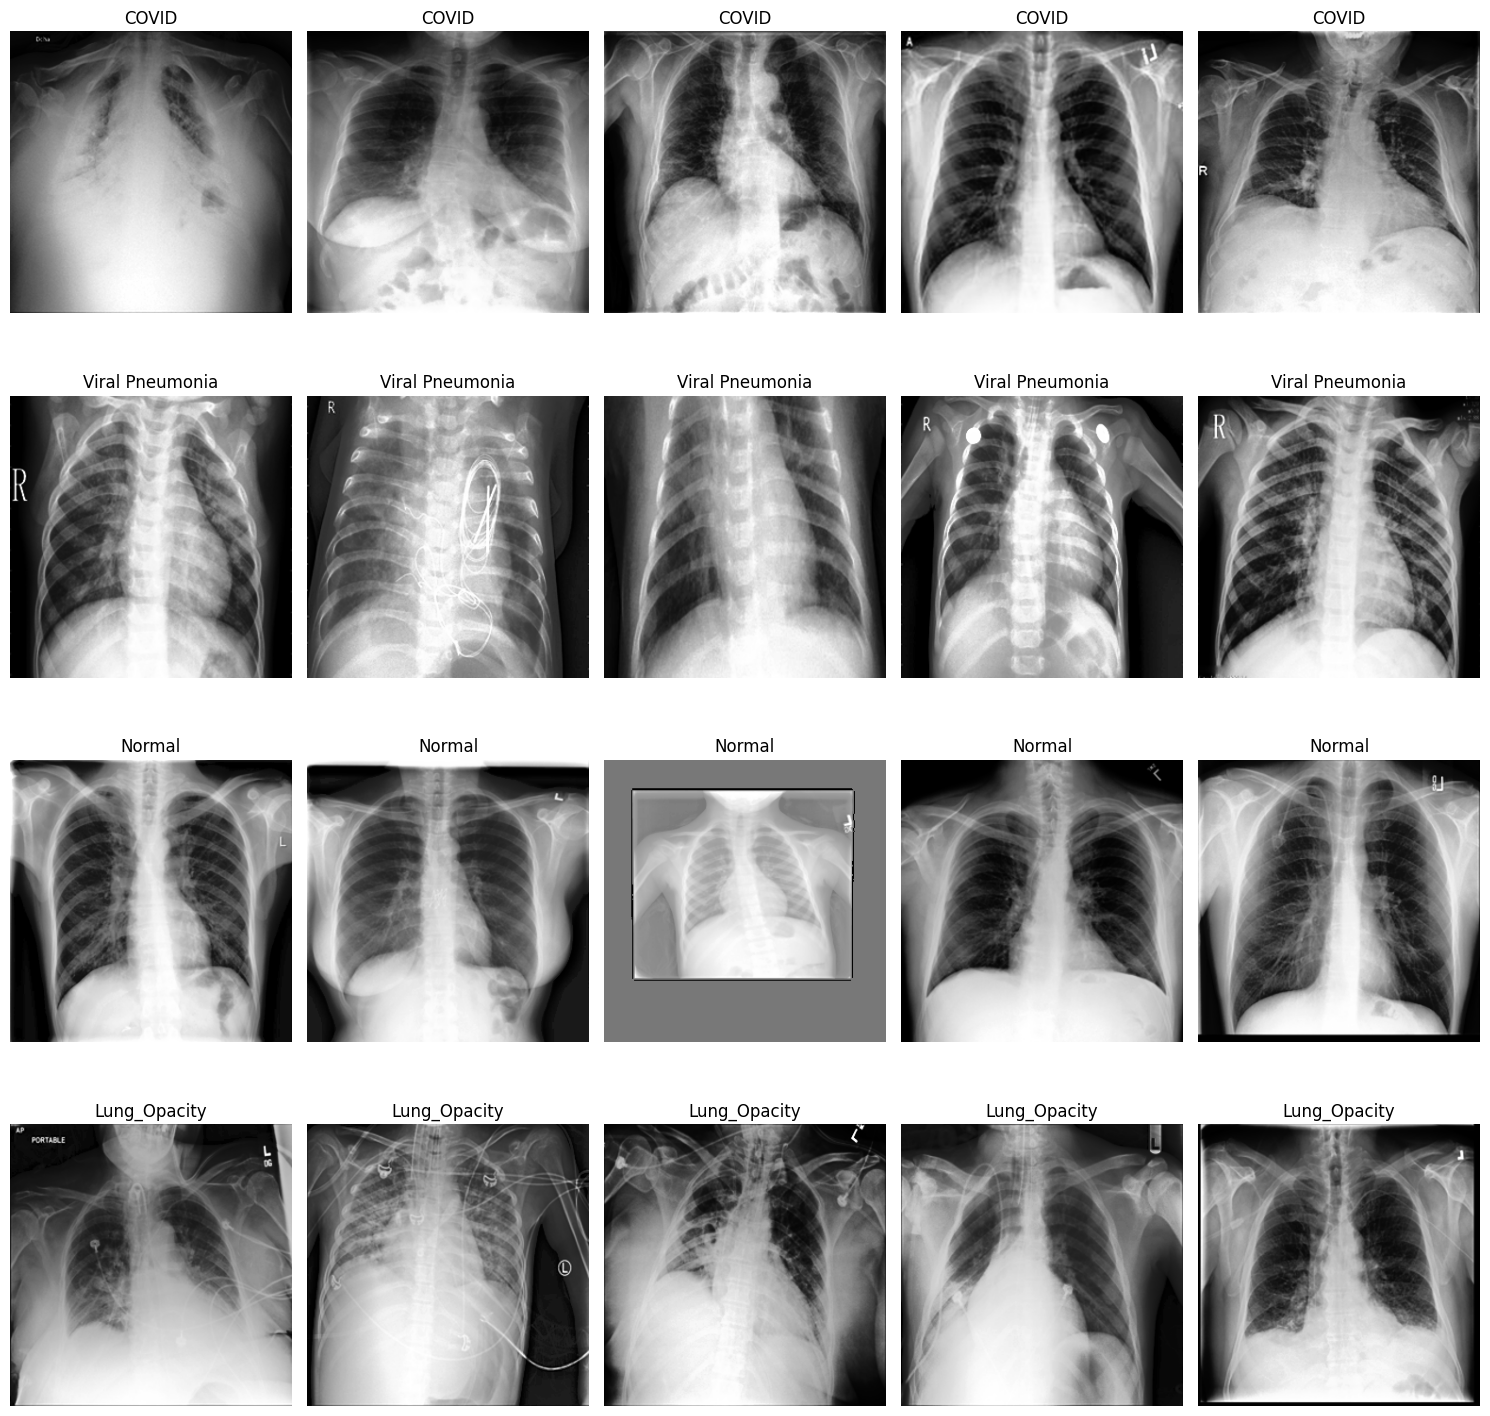

In [25]:
display_images_in_grid('/content/COVID-19_Radiography_Dataset_Processed', num_images_per_class=5)

After applying Histogram equalization the image constrast has been illuminated overall. The shape of white section within the lungs is more precise.

Now, the difference between the classes is more clear.

In [22]:
def compare(img_path):
  img = cv.imread(img_path)
  fig = plt.figure(figsize=(20,15))
  ax1 = fig.add_subplot(2,2,1)
  ax1.imshow(img)
  plt.title("Original image")
  eq_img = hisEqulColor(img)
  ax2 = fig.add_subplot(2,2,2)
  plt.title("Equalized image")
  ax2.imshow(eq_img)

  ax3 = fig.add_subplot(2,2,3)
  ax3.hist(img.ravel())
  plt.title("Original image histogram")

  ax4 = fig.add_subplot(2,2,4)
  ax4.hist(eq_img.ravel())
  plt.title("Equalized image histogram")

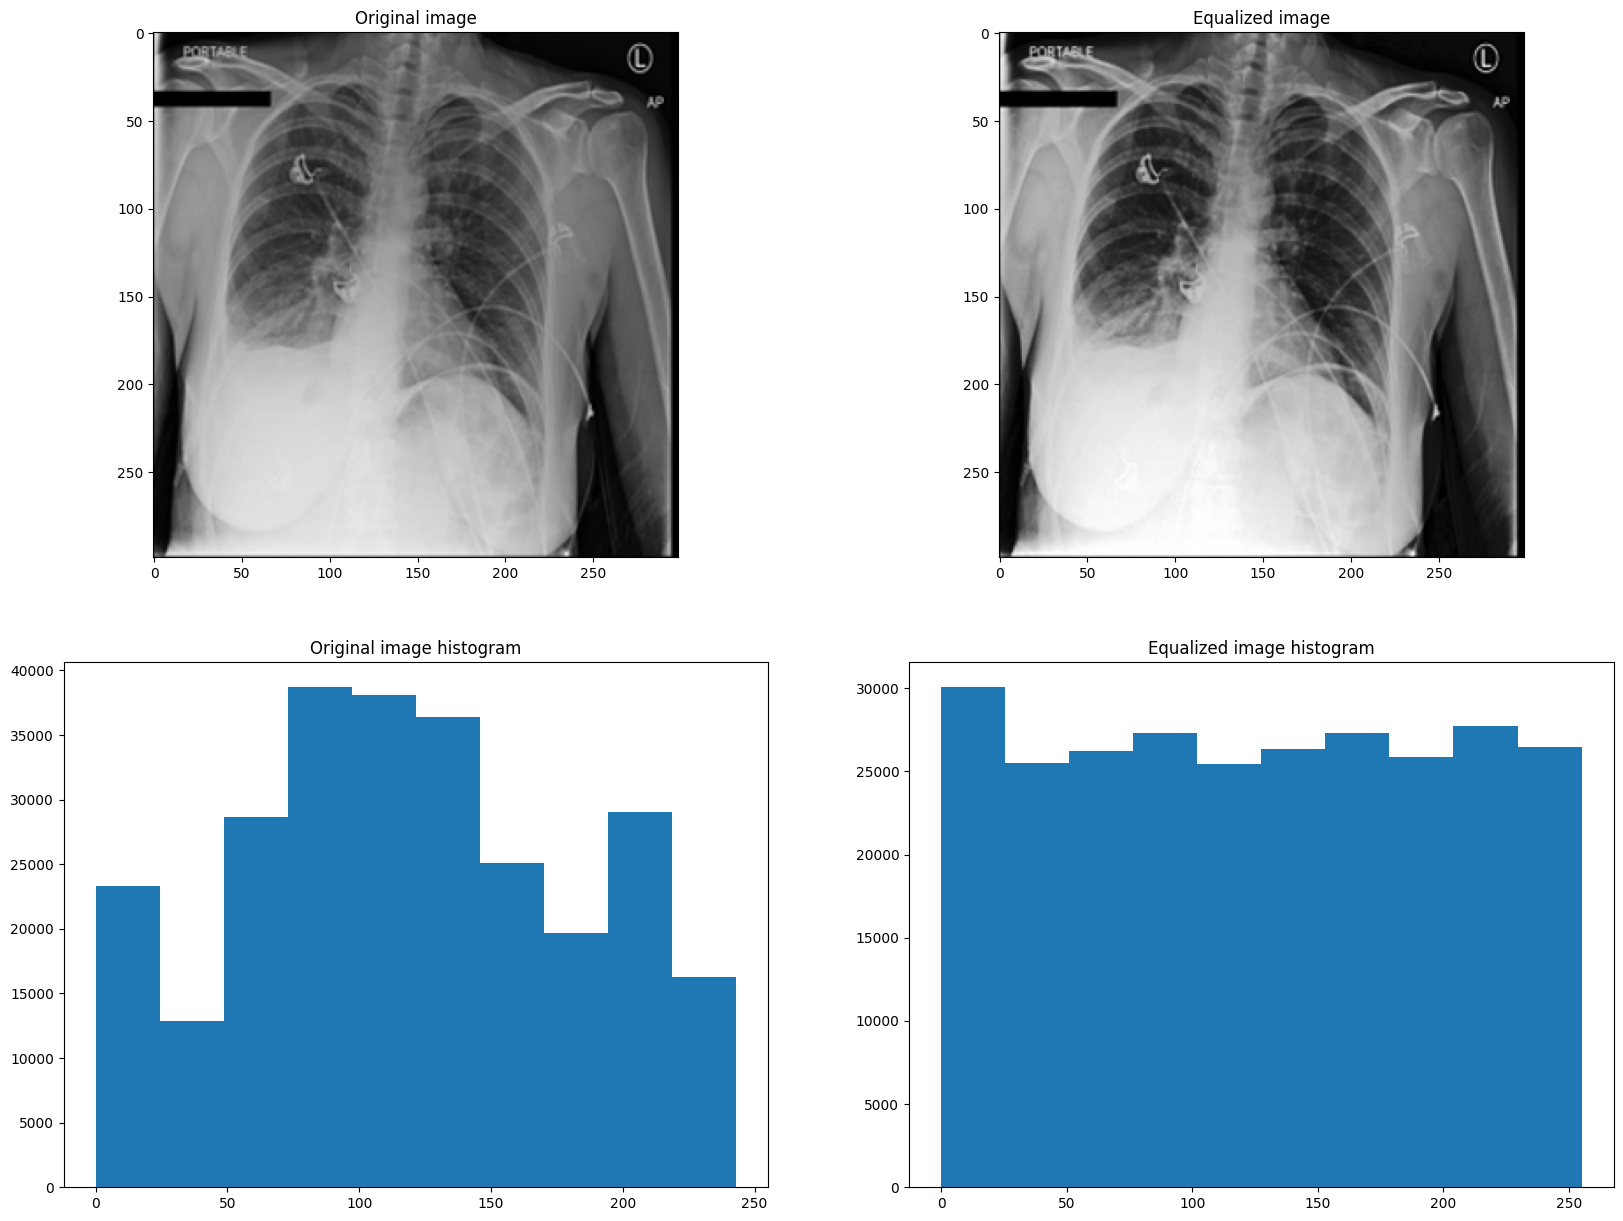

In [24]:
compare('/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-100.png')

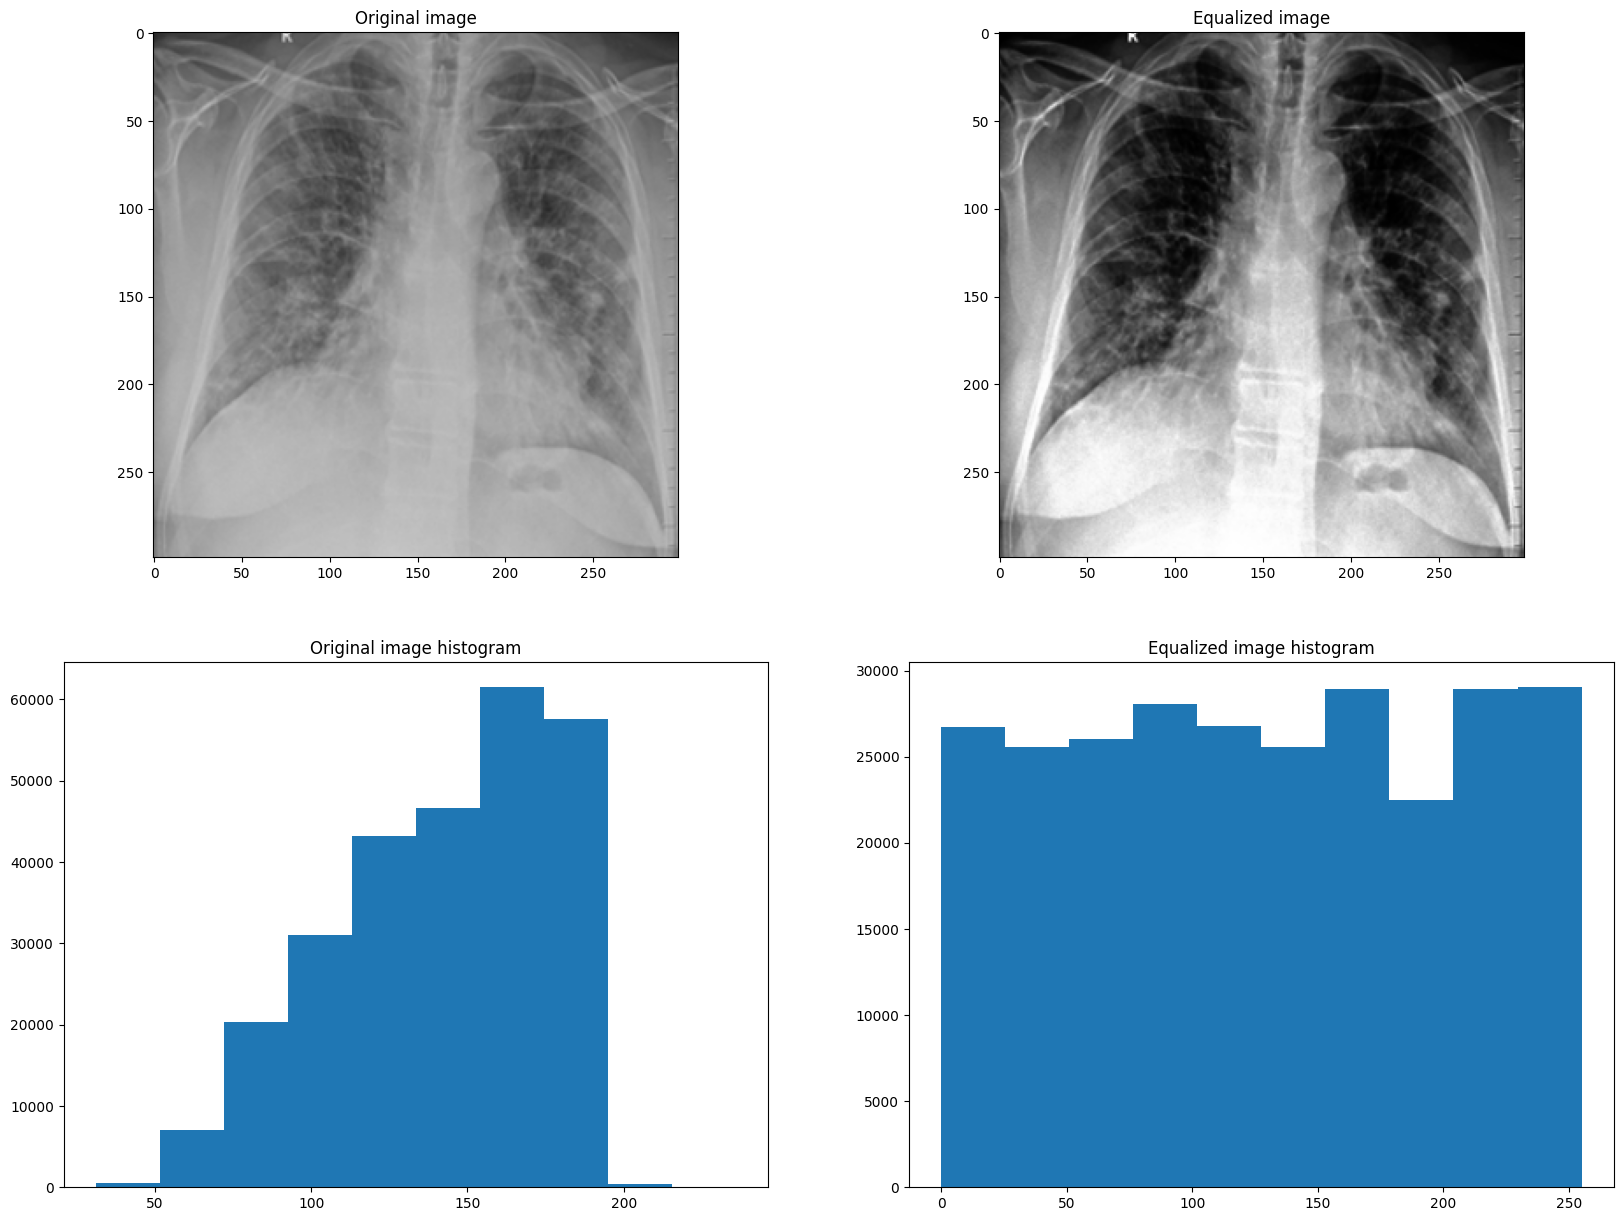

In [26]:
compare('/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1020.png')

Above it can be seen the effect of histogram equalization on the image histogram

In [14]:
os.listdir('/content/COVID-19_Radiography_Dataset')

['Lung_Opacity.metadata.xlsx',
 'COVID.metadata.xlsx',
 'COVID',
 'Viral Pneumonia',
 'README.md.txt',
 'Normal',
 'Normal.metadata.xlsx',
 'Lung_Opacity',
 'Viral Pneumonia.metadata.xlsx']

In [12]:
img = ImageDataGenerator(rescale = 1./255,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split=0.2)

train = img.flow_from_directory(r"/content/COVID-19_Radiography_Dataset_Processed", class_mode="categorical", shuffle=False, batch_size=batch_size, target_size=(dimen, dimen), subset="training")
val = img.flow_from_directory(r"/content/COVID-19_Radiography_Dataset_Processed", class_mode="categorical", shuffle=False, batch_size=batch_size, target_size=(dimen, dimen), subset="validation")

Found 8933 images belonging to 4 classes.
Found 2232 images belonging to 4 classes.


In [14]:
train.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [15]:

vgg16 = VGG16(weights='imagenet', input_shape=(dimen, dimen, 3), include_top=False)
for layer in vgg16.layers:
            layer.trainable = False

#input_tensor = keras.Input(shape=(224, 224, 1))
#x = keras.layers.Conv2D(3, (3, 3), padding='same')(input_tensor)

#x = vgg16(x)
x = Flatten()(vgg16.output)
#for i in range(hp.Int('n_hiddden_layers', 1,5)):
#  x = Dense(hp.Choice('units', values = [512, 720, 1024]), activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg16.inputs, outputs=predictions)

# optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001]), beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
history = model.fit(
    train,
    #class_weight=class_weights,
    #steps_per_epoch= 30,
    validation_data=val,
    #validation_steps=len(val),
    epochs=20,
    #callbacks=[checkpoint]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


121/121 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.4037 - loss: 3.7751 - val_accuracy: 0.5430 - val_loss: 2.1555
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.5207 - loss: 1.7238 - val_accuracy: 0.7106 - val_loss: 0.9277
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.6753 - loss: 1.2815 - val_accuracy: 0.7881 - val_loss: 0.6455
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.7220 - loss: 0.8850 - val_accuracy: 0.7159 - val_loss: 0.8516
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.7373 - loss: 0.8139 - val_accuracy: 0.8445 - val_loss: 0.4224
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.7225 - loss: 1.0094 - val_accuracy: 0.6967 - val_loss: 1.0530
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7443 - loss: 0.8568 - val_accuracy: 0.6761 - val_loss: 1.1230
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.8077 - loss: 0.6481 - val_accuracy: 0.693

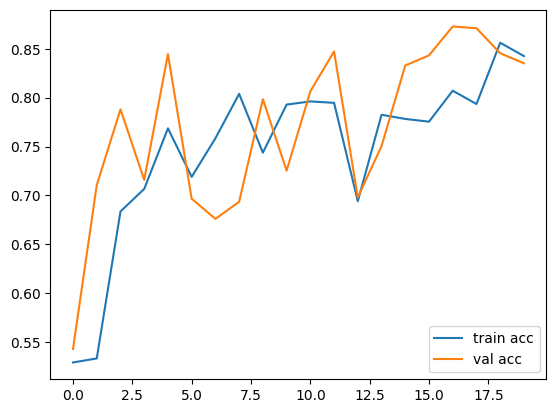

In [18]:

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('acc-graph.png')
plt.show()

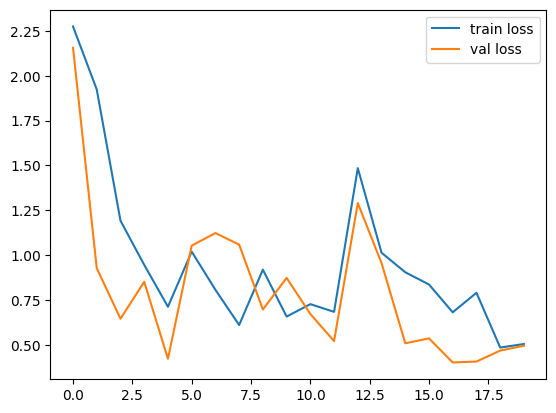

In [19]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()

plt.savefig('loss-graph.png')
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
preds = model.predict(val)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step
[0 0 0 ... 2 3 3]


In [24]:
g_dict = val.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(val.classes, y_pred)
#plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(val.classes, y_pred, target_names= classes))

                 precision    recall  f1-score   support

          COVID       0.76      0.97      0.85       723
   Lung_Opacity       0.88      0.86      0.87       602
         Normal       0.92      0.66      0.77       638
Viral Pneumonia       0.89      0.92      0.91       269

       accuracy                           0.84      2232
      macro avg       0.86      0.85      0.85      2232
   weighted avg       0.86      0.84      0.84      2232



In [25]:
import seaborn as sns

<Axes: >

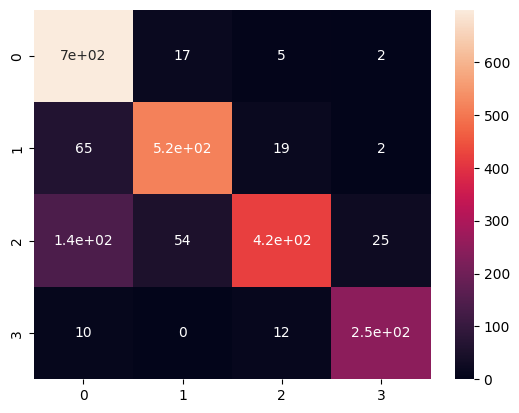

In [26]:
sns.heatmap(cm, annot = True)